In [1]:
!git clone https://github.com/januar-png/earlystop.git

Cloning into 'earlystop'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 59 (delta 31), reused 17 (delta 7), pack-reused 0
Receiving objects: 100% (59/59), 858.20 KiB | 6.65 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [2]:
from earlystop import Earlystop

In [3]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
batch_size = 32
img_size = 224

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomVerticalFlip(),    
    transforms.RandomRotation(7),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize(size=(img_size)),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('/kaggle/input/dataset-rice-leaf/RiceLeafsDisease/train', transform = train_transform)
trainloader = DataLoader(train_set, batch_size, shuffle = True)

val_set = datasets.ImageFolder('/kaggle/input/dataset-rice-leaf/RiceLeafsDisease/validation', transform = val_transform)
valloader = DataLoader(val_set, batch_size, shuffle = False)

In [6]:
1600/64

25.0

In [15]:
def ConvBlock(in_channels, out_channels, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels),
        nn.BatchNorm2d(in_channels),
        nn.ReLU(inplace = True),
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True),
    )

In [16]:
class CNNpenyakitPadi(nn.Module):
    def __init__(self, output_size):
        super(CNNpenyakitPadi, self).__init__()
        self.feature = nn.Sequential(

            ConvBlock(3, 32),
            nn.MaxPool2d(2,2),
            
            ConvBlock(32, 64),
            nn.MaxPool2d(2,2),
            
            ConvBlock(64, 128),
            nn.MaxPool2d(2,2),
            
            ConvBlock(128, 128),
            nn.MaxPool2d(2,2),
            
            ConvBlock(128, 512),
            nn.MaxPool2d(2,2),
        
        )
        self.flatten = nn.Flatten()
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(512,output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [17]:
model = CNNpenyakitPadi(len(train_set.classes))
model

CNNpenyakitPadi(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2,

In [18]:
from tqdm import tqdm

In [19]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [20]:
def fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, early_stop, epochs):
    for epoch in range(epochs):
        train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
        with torch.no_grad():
            test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)

        early_stop.log(train_cost, test_cost, train_score, test_score)

        if early_stop.early_stopping(model, monitor="test_cost") or epoch >= epochs - 1:
            early_stop.plot_cost()
            early_stop.plot_score()
            break

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNpenyakitPadi(output_size = len(train_set.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
early_stop = Earlystop(model, outdir="model", early_stop_patience=2)
epoch = 100

Test: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


Epoch 1: train_loss=1.7133, val_loss=1.6459, train_score=0.3589, val_score=0.4293


Test: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 2: train_loss=1.5573, val_loss=1.5267, train_score=0.4967, val_score=0.5076


Test: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]


Epoch 3: train_loss=1.4970, val_loss=1.4934, train_score=0.5768, val_score=0.5530


Test: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


Epoch 4: train_loss=1.4597, val_loss=1.4562, train_score=0.6225, val_score=0.6035


Test: 100%|██████████| 13/13 [00:09<00:00,  1.30it/s]


Epoch 5: train_loss=1.4225, val_loss=1.4162, train_score=0.6852, val_score=0.6616


Test: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 6: train_loss=1.3769, val_loss=1.3807, train_score=0.7255, val_score=0.6894


Test: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]


Epoch 7: train_loss=1.3617, val_loss=1.3571, train_score=0.7206, val_score=0.7247


Test: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]


Epoch 8: train_loss=1.3370, val_loss=1.3360, train_score=0.7413, val_score=0.7424


Test: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 9: train_loss=1.3220, val_loss=1.3323, train_score=0.7522, val_score=0.7247


Test: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]


Epoch 10: train_loss=1.3167, val_loss=1.3255, train_score=0.7489, val_score=0.7298


Test: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


Epoch 11: train_loss=1.3074, val_loss=1.3202, train_score=0.7587, val_score=0.7298


Test: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


Epoch 12: train_loss=1.3004, val_loss=1.3031, train_score=0.7582, val_score=0.7626


Test: 100%|██████████| 13/13 [00:10<00:00,  1.30it/s]


Epoch 13: train_loss=1.2983, val_loss=1.2994, train_score=0.7636, val_score=0.7626


Test: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


Epoch 14: train_loss=1.2975, val_loss=1.2901, train_score=0.7593, val_score=0.7803


Test: 100%|██████████| 13/13 [00:10<00:00,  1.30it/s]


Epoch 15: train_loss=1.2879, val_loss=1.3033, train_score=0.7702, val_score=0.7551
EarlyStop patience =  1. Best test_cost: 1.2901


Test: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Epoch 16: train_loss=1.2860, val_loss=1.2838, train_score=0.7767, val_score=0.7753


Test: 100%|██████████| 13/13 [00:10<00:00,  1.30it/s]


Epoch 17: train_loss=1.2766, val_loss=1.2771, train_score=0.7821, val_score=0.7753


Test: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 18: train_loss=1.2743, val_loss=1.2765, train_score=0.7832, val_score=0.7727


Test: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]


Epoch 19: train_loss=1.2713, val_loss=1.2777, train_score=0.7827, val_score=0.7702
EarlyStop patience =  1. Best test_cost: 1.2765


Test: 100%|██████████| 13/13 [00:10<00:00,  1.30it/s]


Epoch 20: train_loss=1.2707, val_loss=1.2640, train_score=0.7827, val_score=0.7879


Test: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Epoch 21: train_loss=1.2637, val_loss=1.2676, train_score=0.7941, val_score=0.7828
EarlyStop patience =  1. Best test_cost: 1.2640


Test: 100%|██████████| 13/13 [00:09<00:00,  1.30it/s]


Epoch 22: train_loss=1.2628, val_loss=1.2722, train_score=0.7990, val_score=0.7803
EarlyStop patience =  2. Best test_cost: 1.2640
Training early stopped. tidak ada peningkatan pada 2 epoch terakhir atau mencapai target score.
Early Stopping pada epoch: 21 | Best test_cost: 1.2640


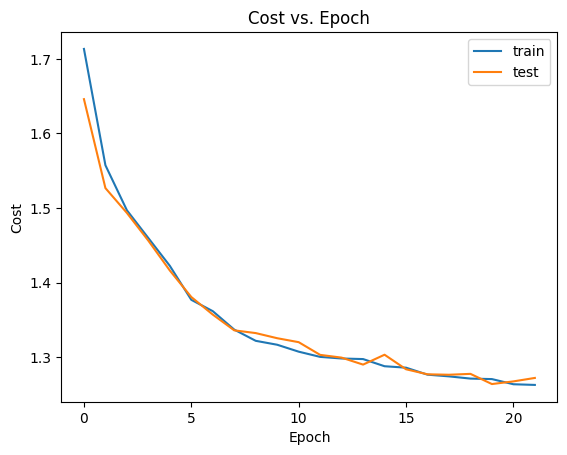

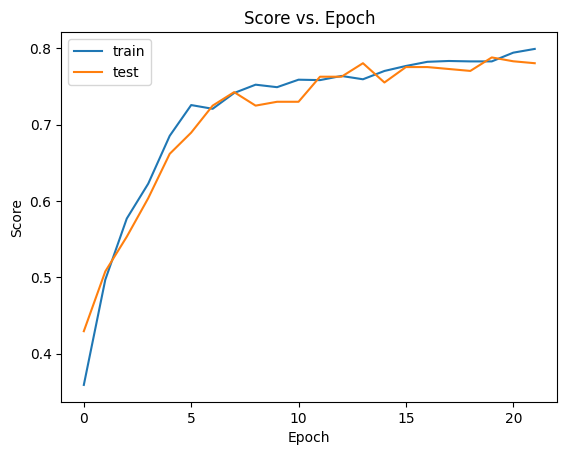

In [22]:
fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, early_stop, epoch)

In [23]:
!pip install torchsummary

In [28]:
test_transform = transforms.Compose([
    transforms.Resize(size=(img_size,img_size)),
    transforms.ToTensor()
])
test_set = datasets.ImageFolder('/kaggle/input/dataset-rice-leaf/RiceLeafsDisease/test', transform=test_transform)
testloader = DataLoader(test_set, shuffle=False)

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
def evaluate_model(model, testloader, criterion, device):
    model.load_state_dict(torch.load('/kaggle/working/model/best_model.pth'))
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    average_loss = total_loss / len(testloader)
    accuracy = sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels)

    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    print("Classification Report:")
    print(classification_report(all_labels, all_predictions))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_set.classes, yticklabels=test_set.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Test Loss: 1.1604, Test Accuracy: 0.9192
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        66
           1       0.93      0.82      0.87        66
           2       0.89      0.94      0.91        66
           3       0.91      0.80      0.85        66
           4       0.96      1.00      0.98        66
           5       0.84      0.98      0.91        66

    accuracy                           0.92       396
   macro avg       0.92      0.92      0.92       396
weighted avg       0.92      0.92      0.92       396

Confusion Matrix:


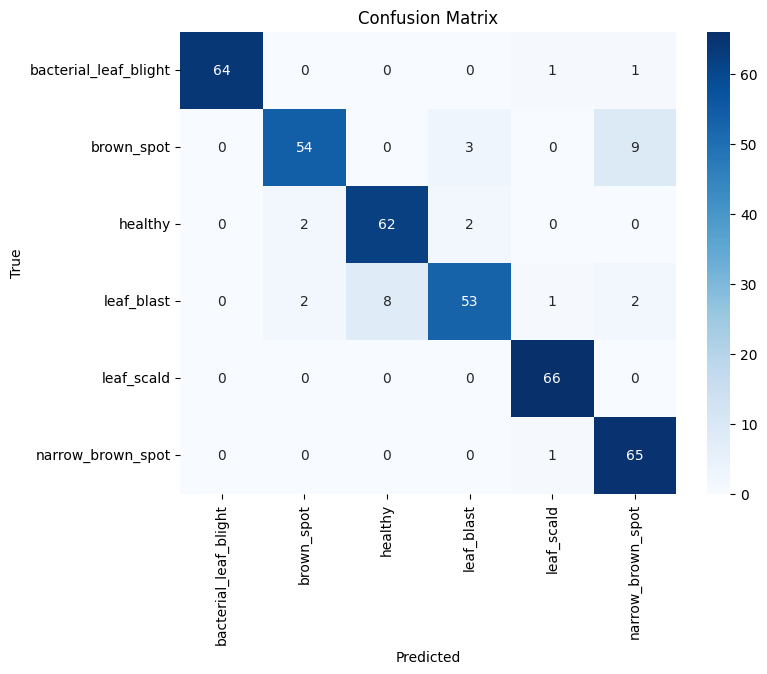

In [31]:
evaluate_model(model, testloader, criterion, device)

In [32]:
from torchsummary import summary

model = CNNpenyakitPadi(output_size = 6).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 224, 224]              30
       BatchNorm2d-2          [-1, 3, 224, 224]               6
              ReLU-3          [-1, 3, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]             128
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 32, 112, 112]             320
       BatchNorm2d-9         [-1, 32, 112, 112]              64
             ReLU-10         [-1, 32, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]           2,112
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

In [33]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)

early_stop.reset_early_stop()
early_stop.early_stop_patience = 5
epoch = 30

In [ ]:
fit(train_set, trainloader, test_set, testloader, model, criterion, optimizer, device, early_stop, epoch)

In [42]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image


activation1 = {}
jumlah = 100

def get_activation(name):
    def hook(module, input, output):
        activation1[name] = output.detach()
    return hook

model.feature[0][0].register_forward_hook(get_activation('conv'))
model.feature[0][3].register_forward_hook(get_activation('conv1'))
model.feature[2][0].register_forward_hook(get_activation('conv2'))
model.feature[2][3].register_forward_hook(get_activation('conv3'))
model.feature[4][0].register_forward_hook(get_activation('conv4'))
model.feature[4][3].register_forward_hook(get_activation('conv5'))

model.feature[0][2].register_forward_hook(get_activation('relu'))
model.feature[0][5].register_forward_hook(get_activation('relu1'))
model.feature[2][2].register_forward_hook(get_activation('relu3'))
model.feature[2][5].register_forward_hook(get_activation('relu4'))
model.feature[4][2].register_forward_hook(get_activation('relu5'))
model.feature[4][5].register_forward_hook(get_activation('relu6'))


img = Image.open('/kaggle/input/dataset-rice-leaf/RiceLeafsDisease/test/brown_spot/brown_val (53).jpg')
rgb_image = img.convert('RGB')

transform = transforms.Compose([
    transforms.Resize(size=(230)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor()
])
img_tensor = transform(rgb_image)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.cuda()

output = model(img_tensor)

/tmp/ipykernel_32/1439365084.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


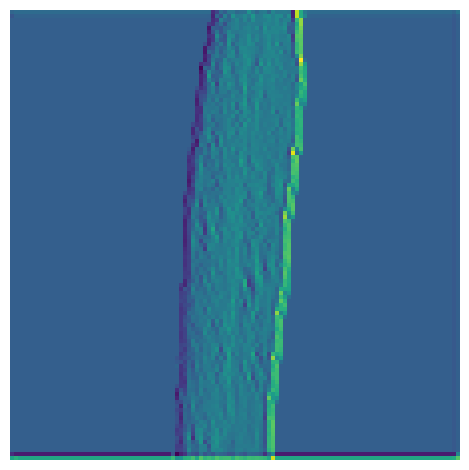

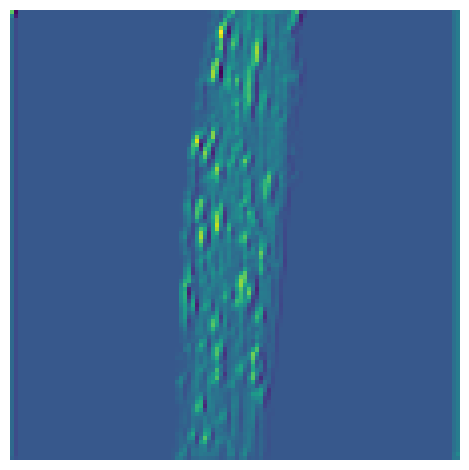

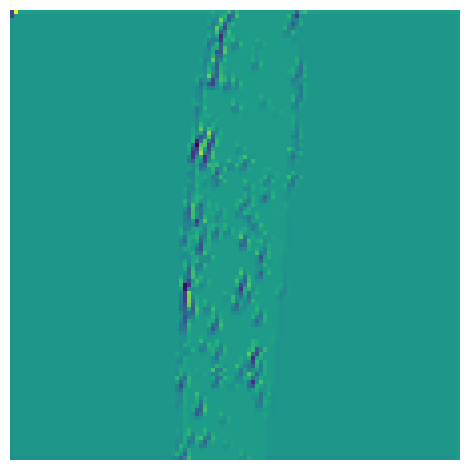

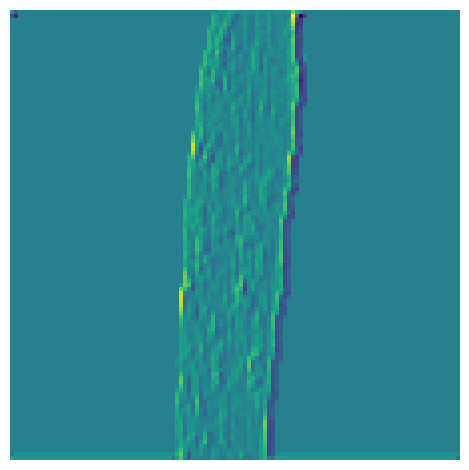

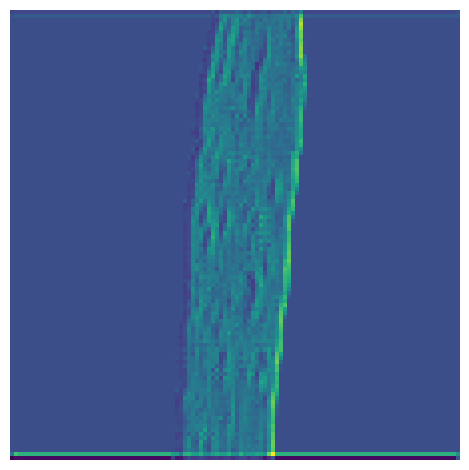

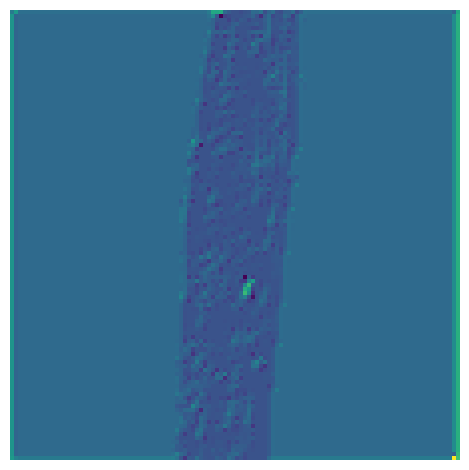

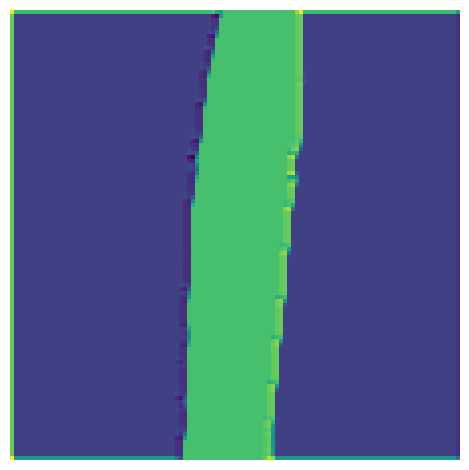

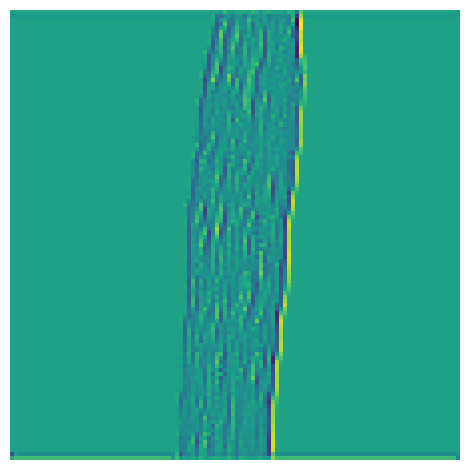

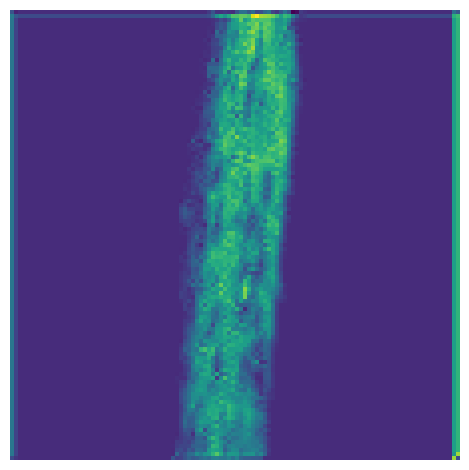

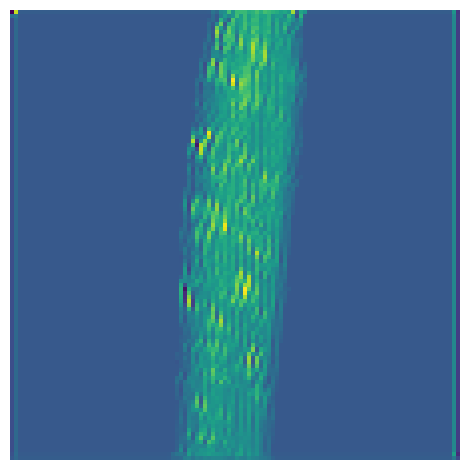

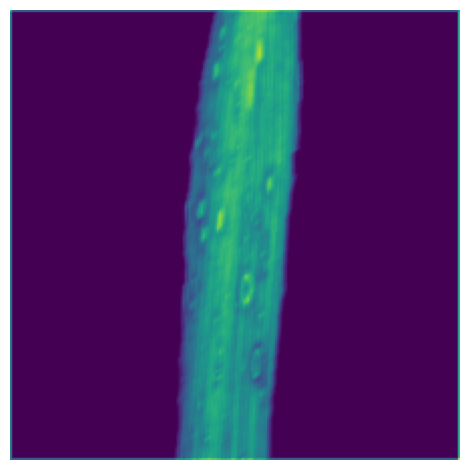

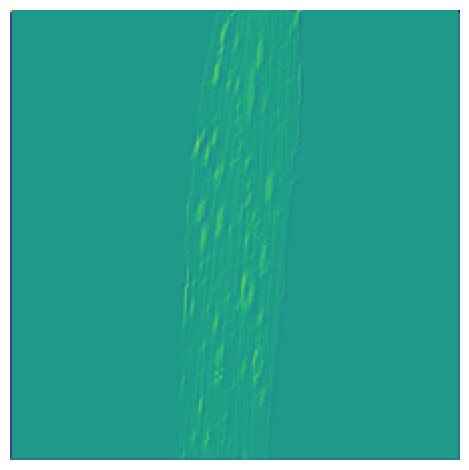

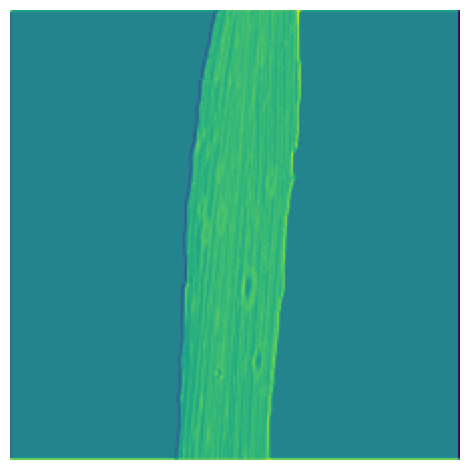

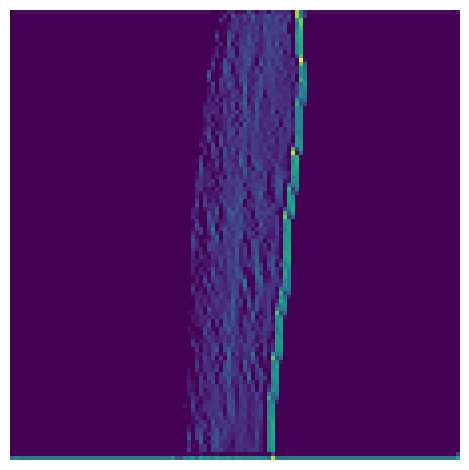

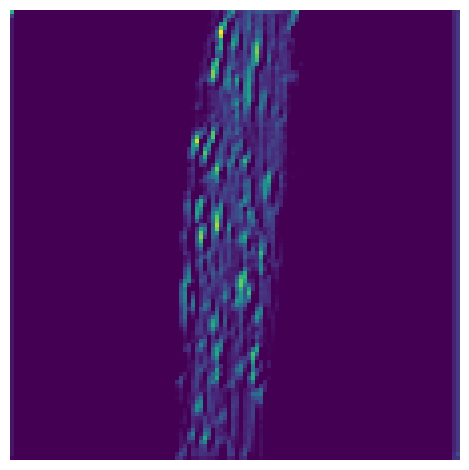

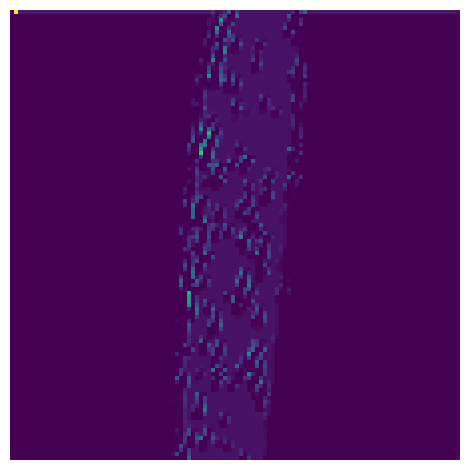

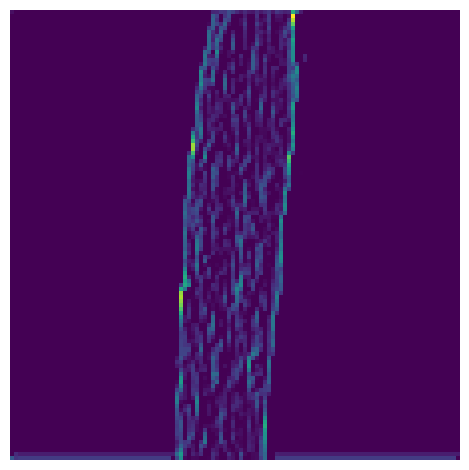

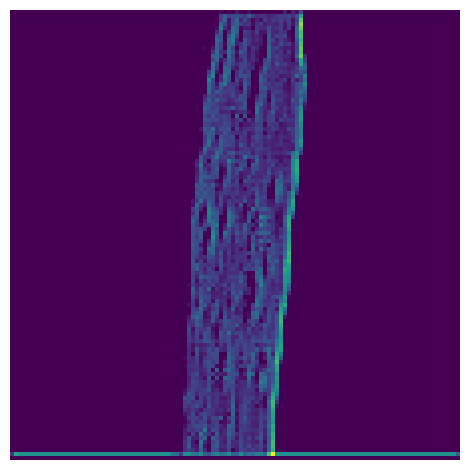

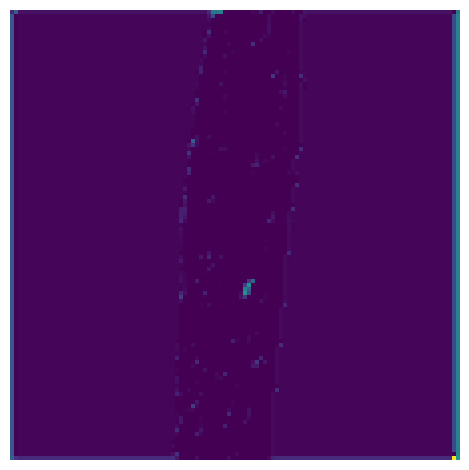

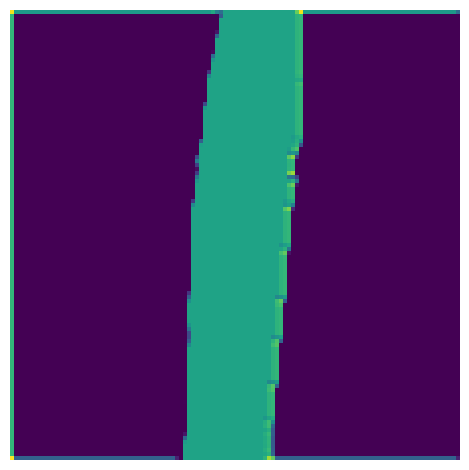

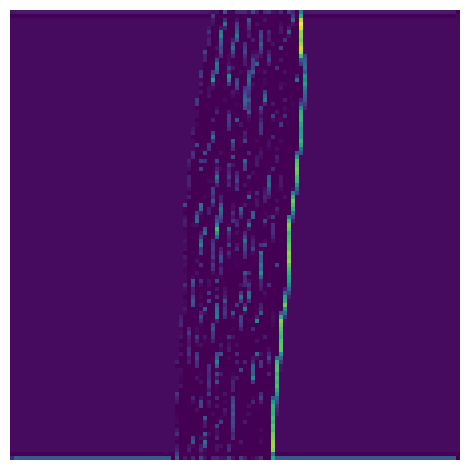

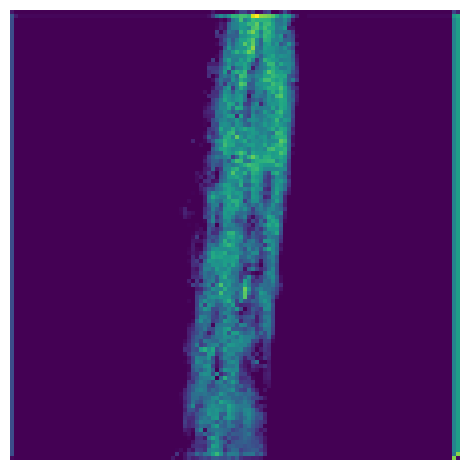

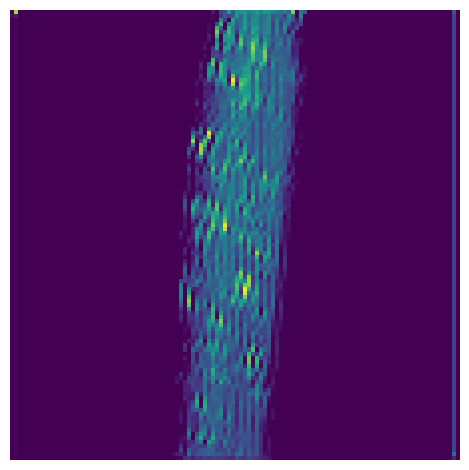

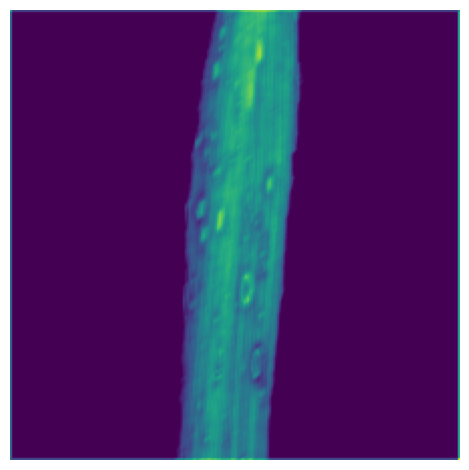

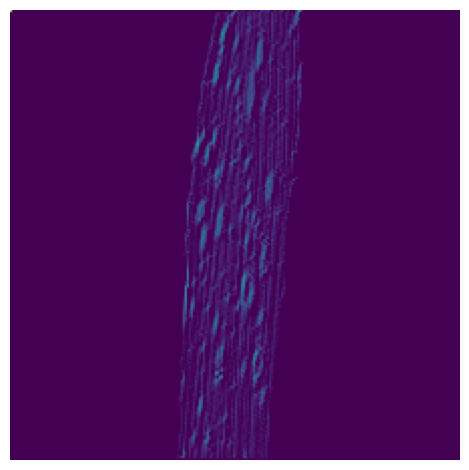

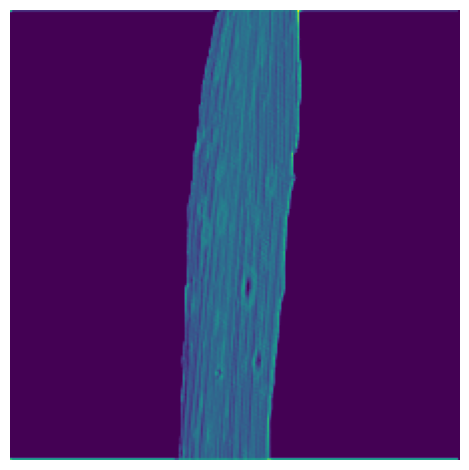

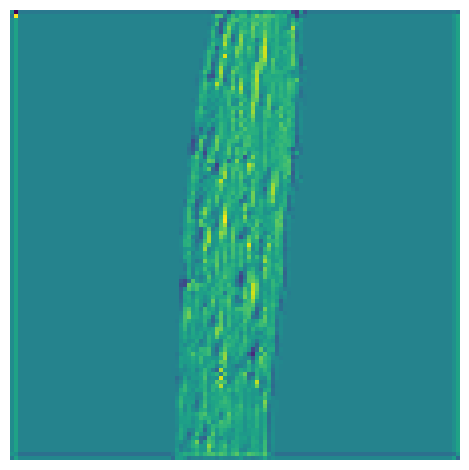

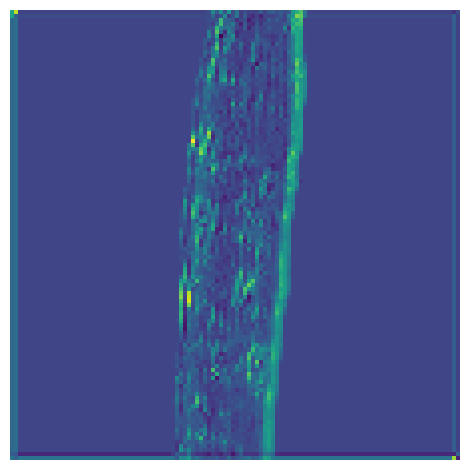

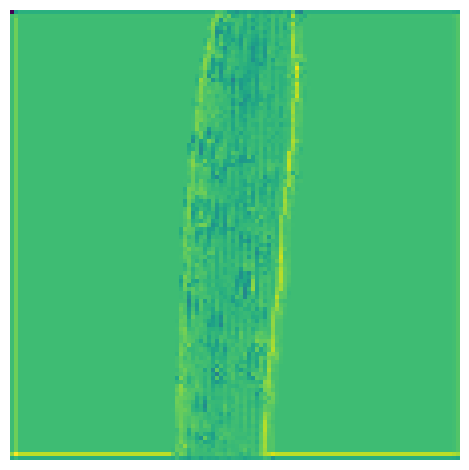

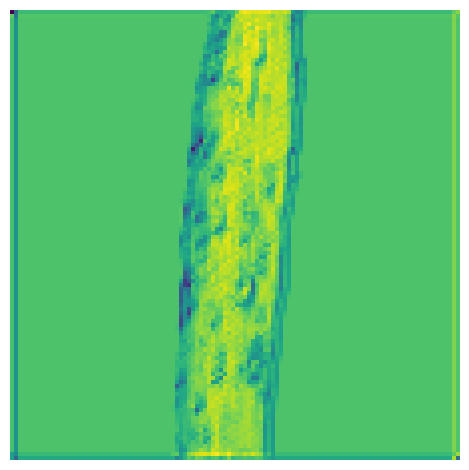

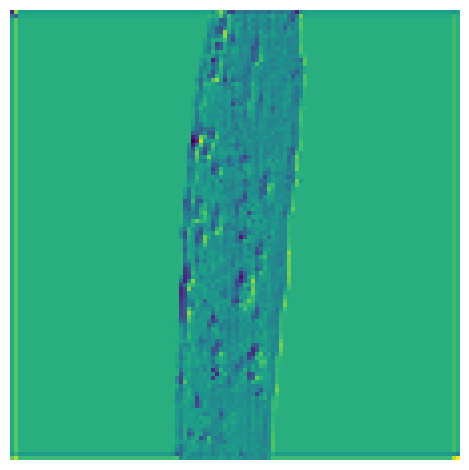

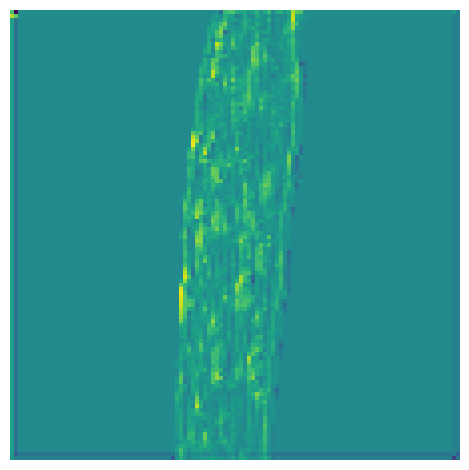

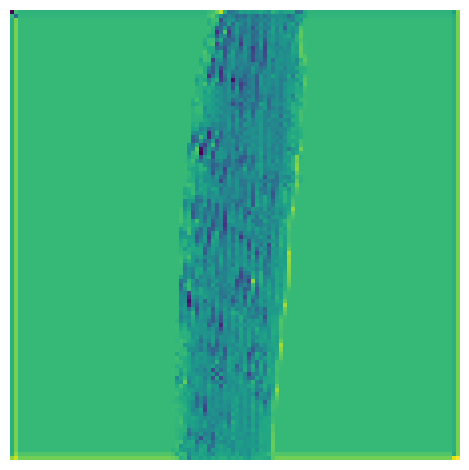

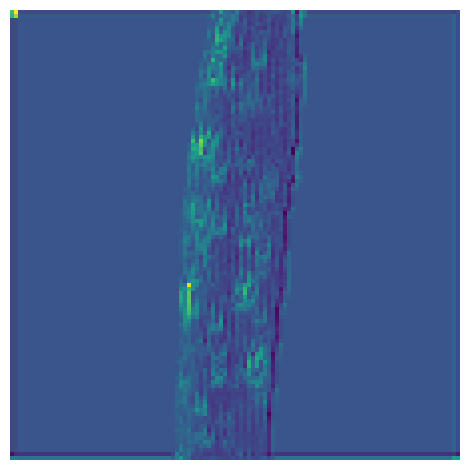

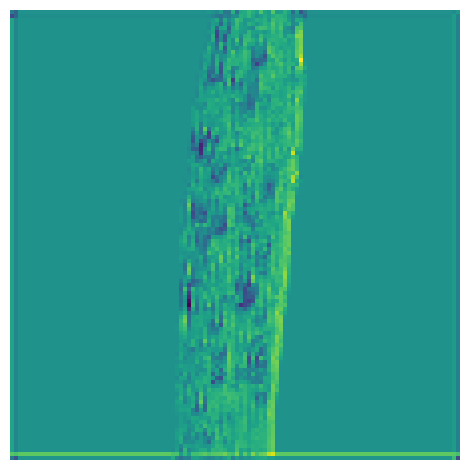

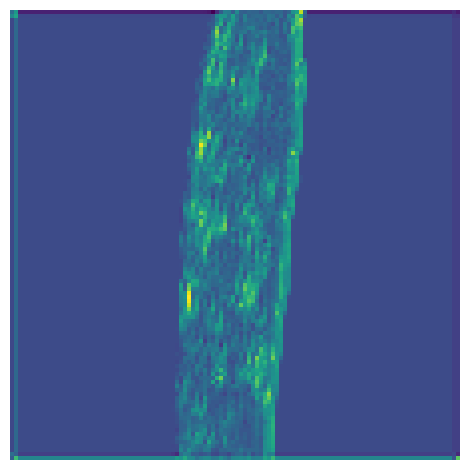

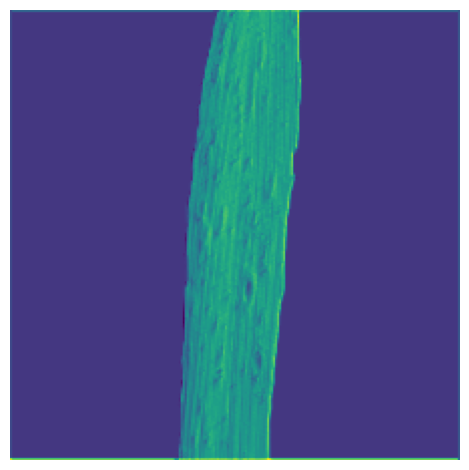

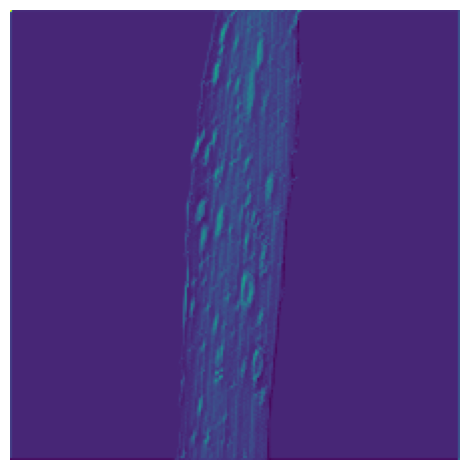

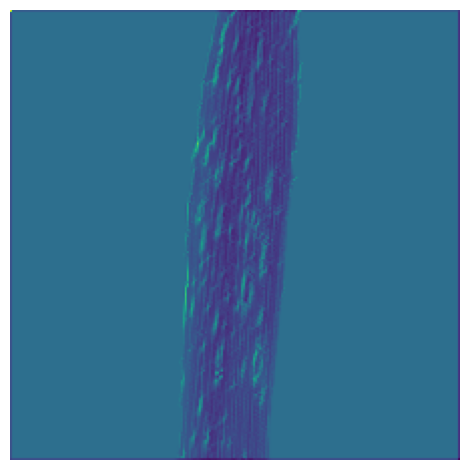

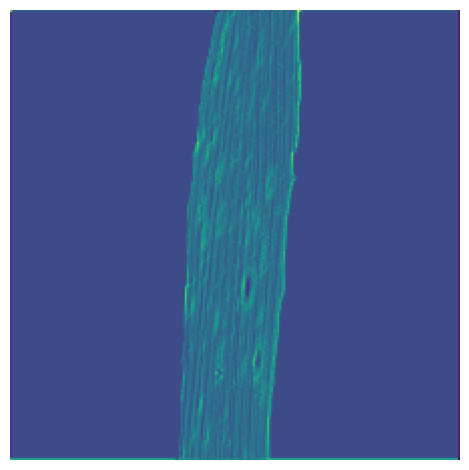

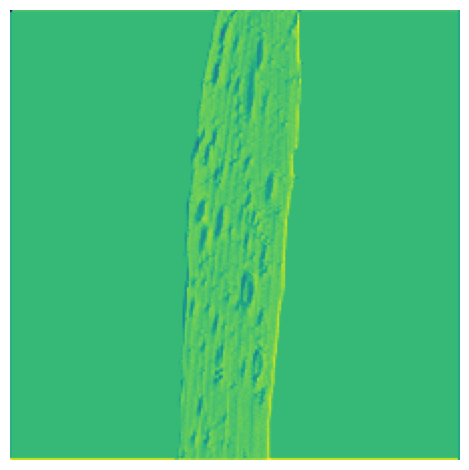

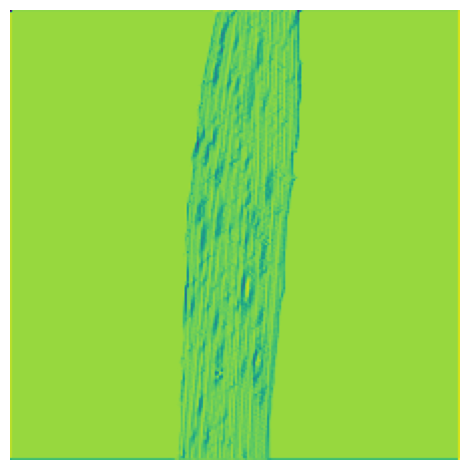

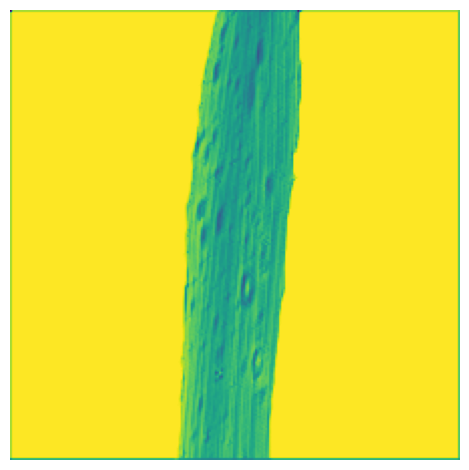

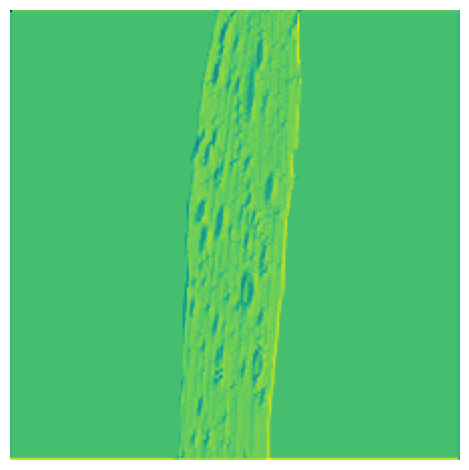

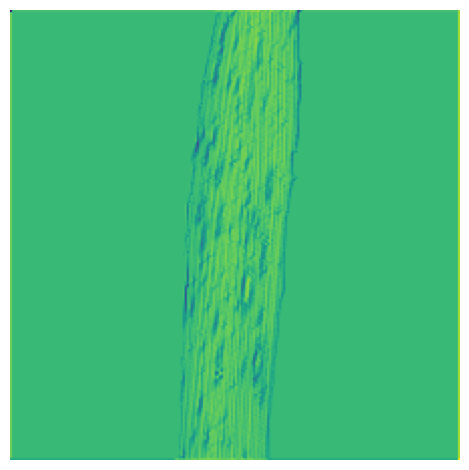

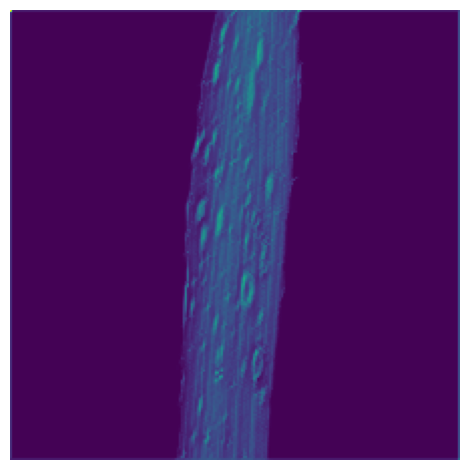

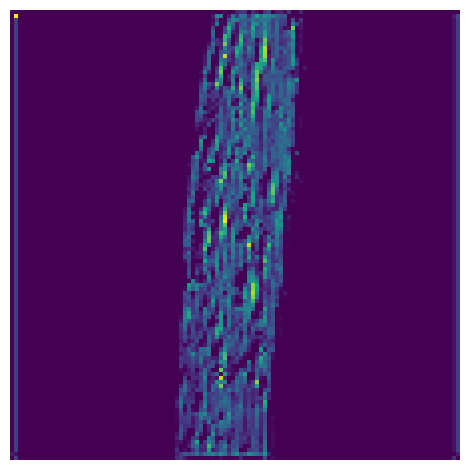

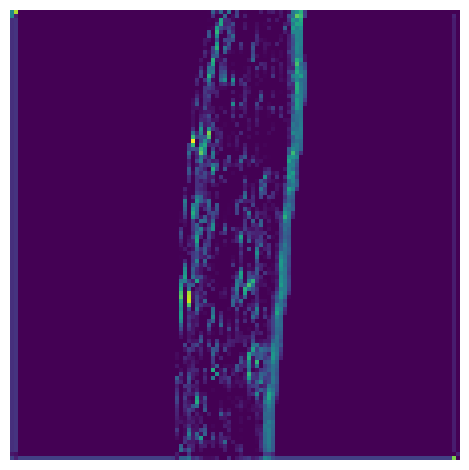

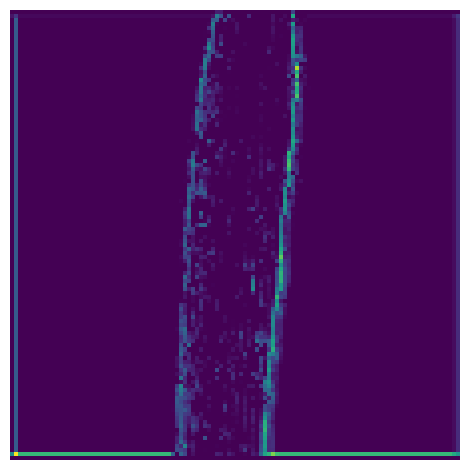

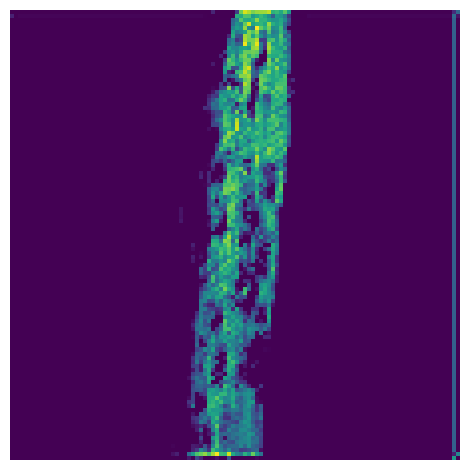

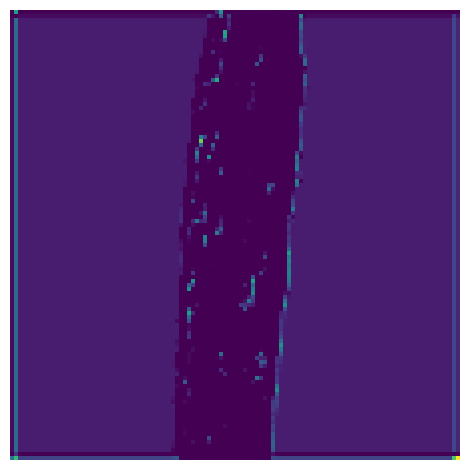

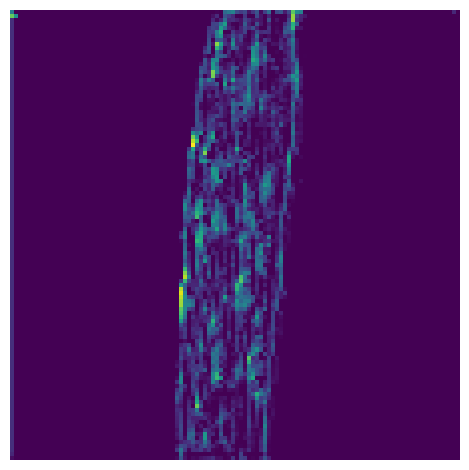

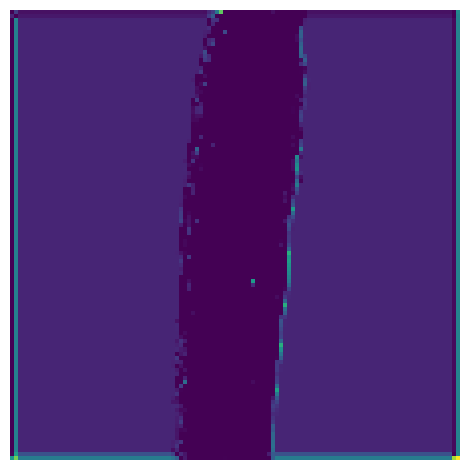

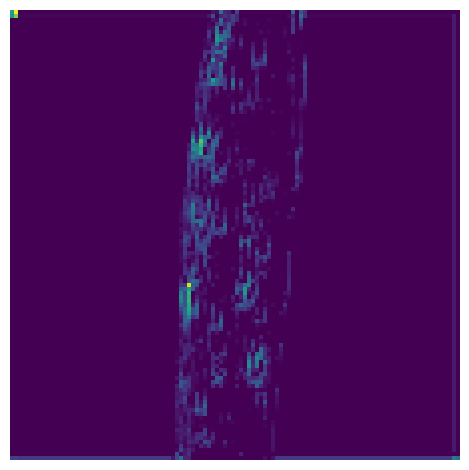

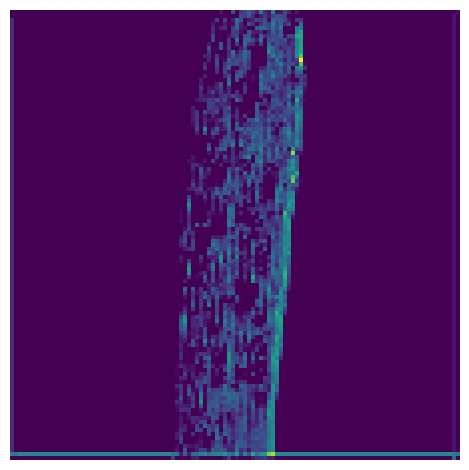

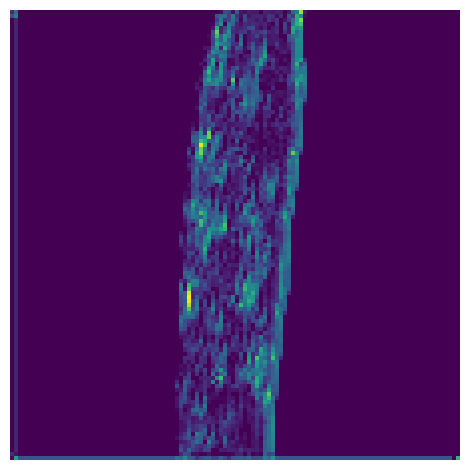

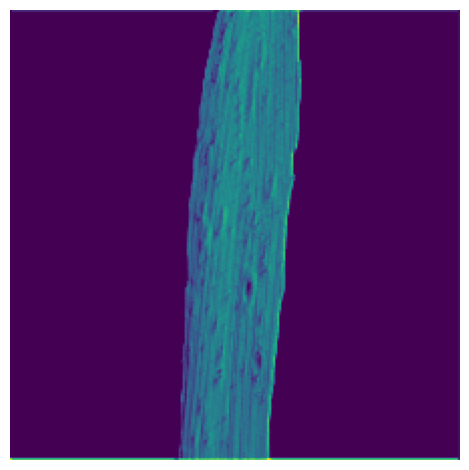

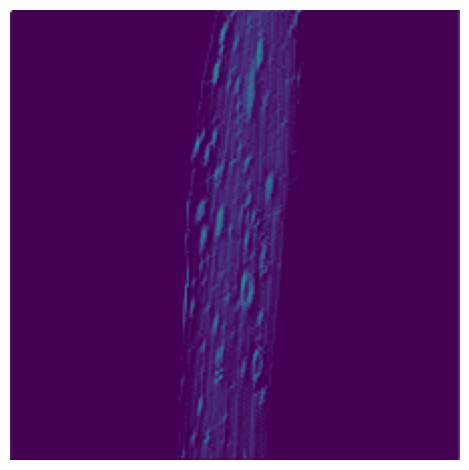

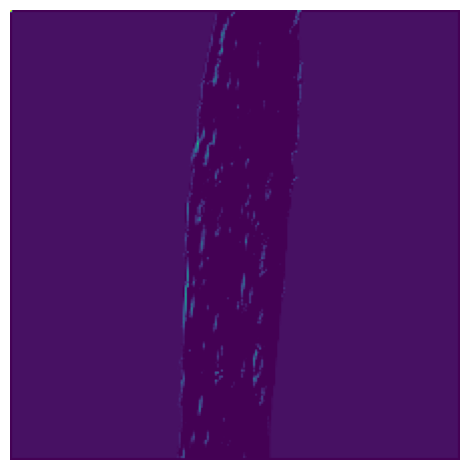

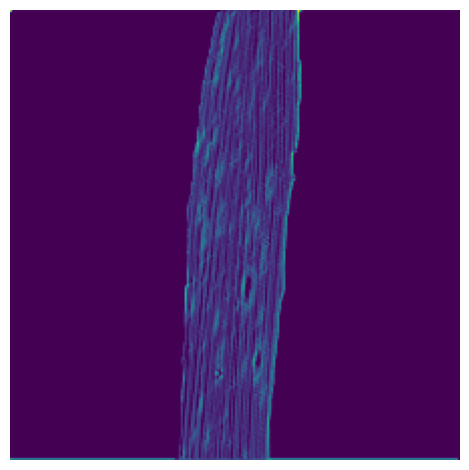

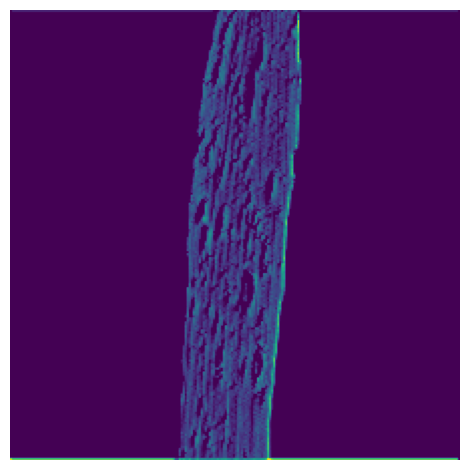

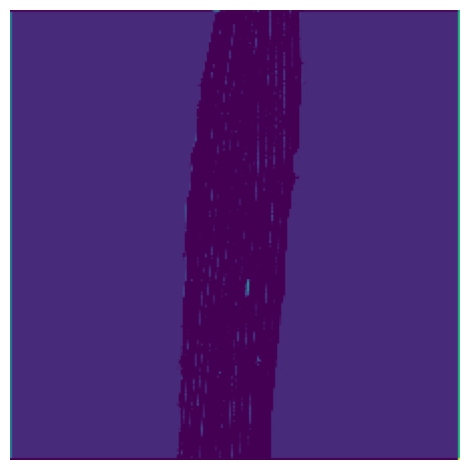

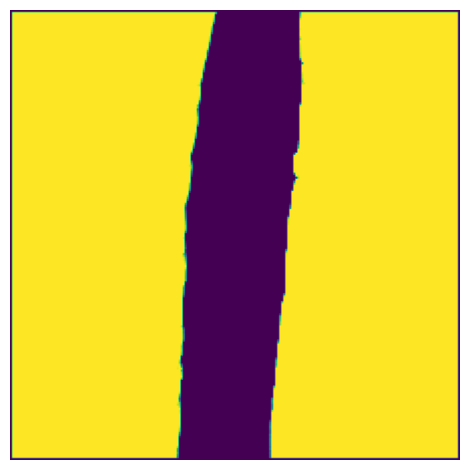

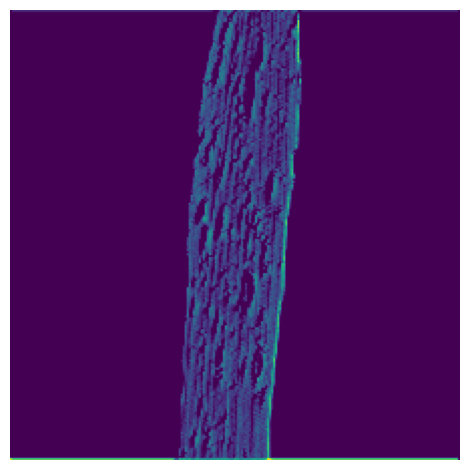

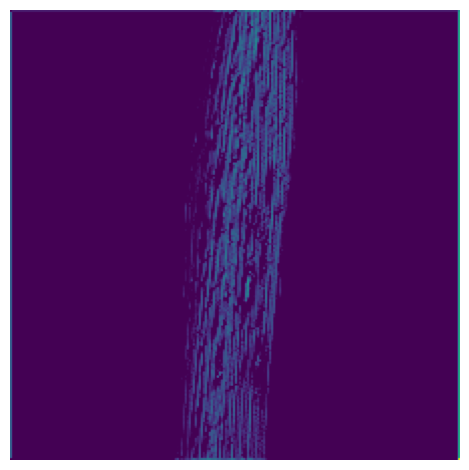

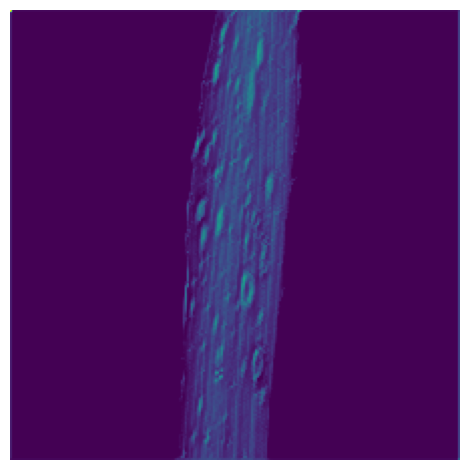

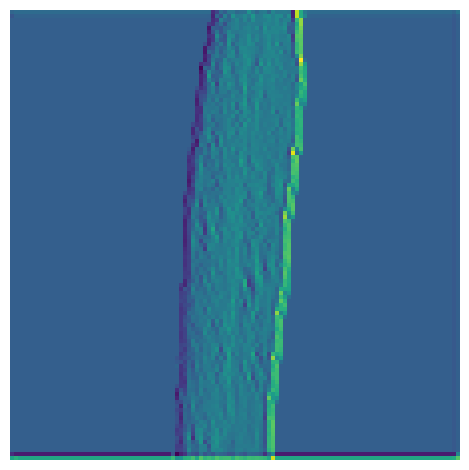

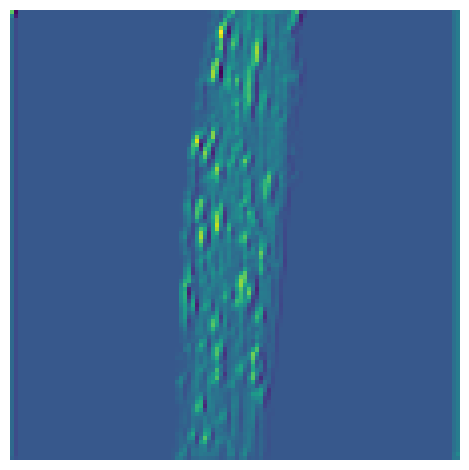

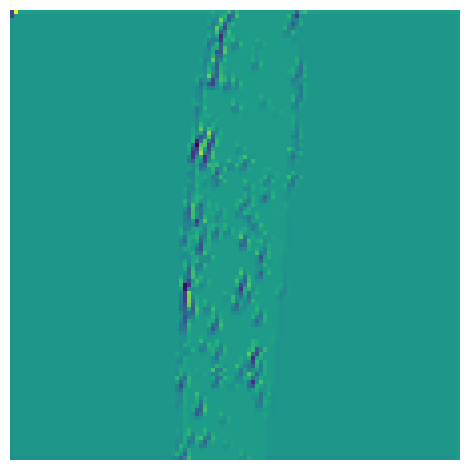

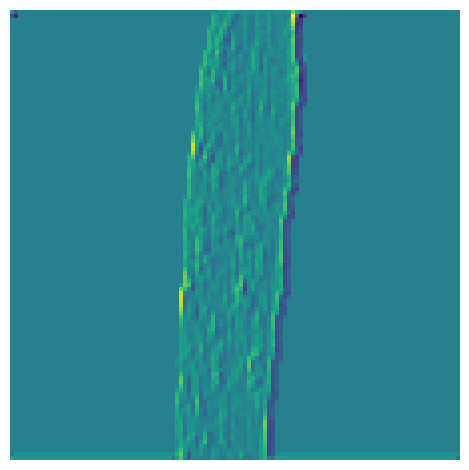

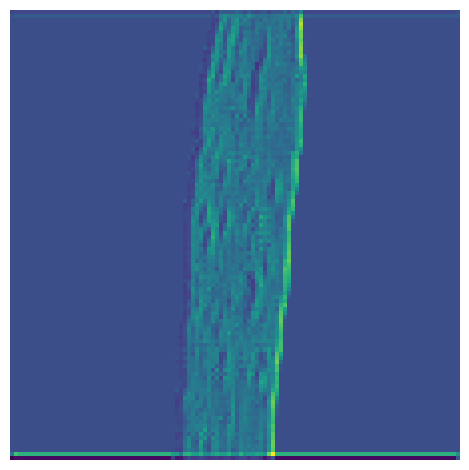

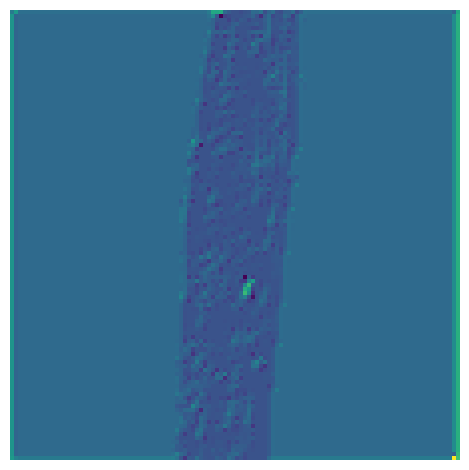

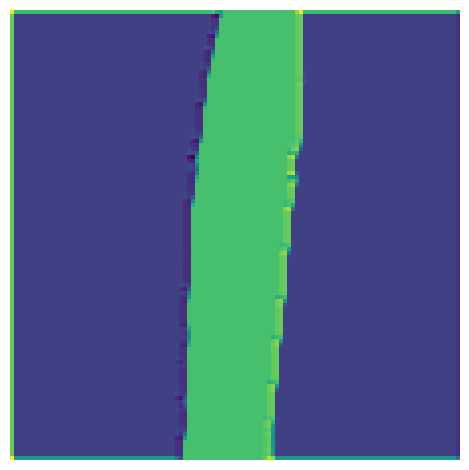

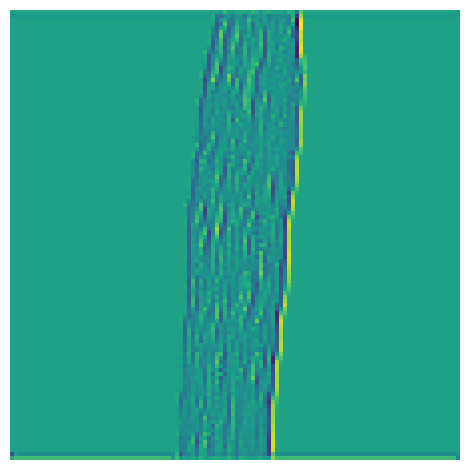

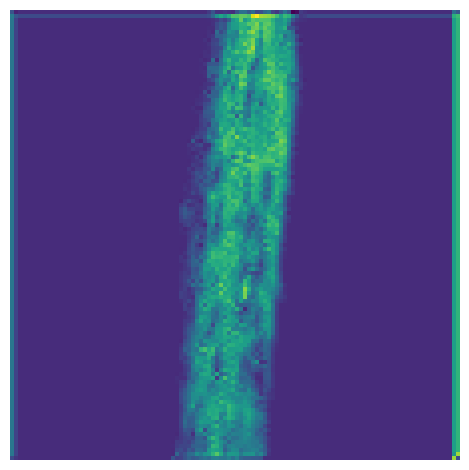

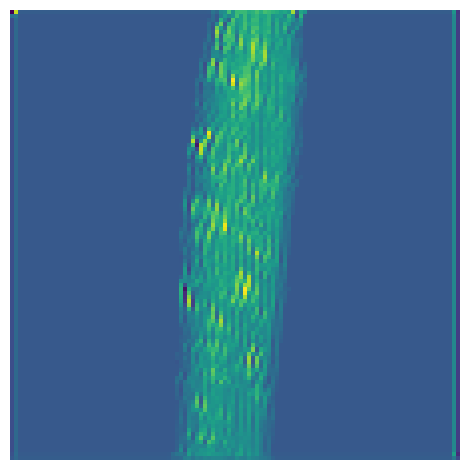

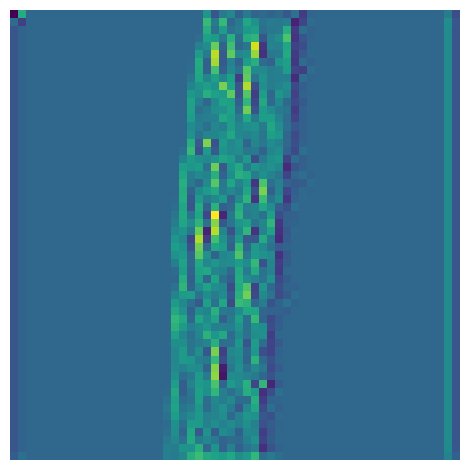

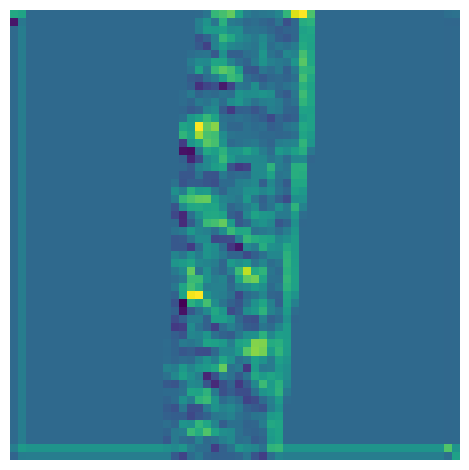

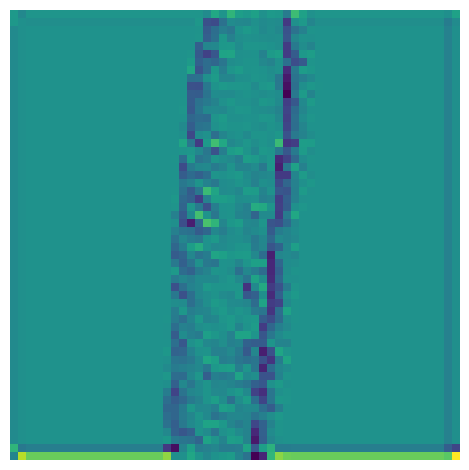

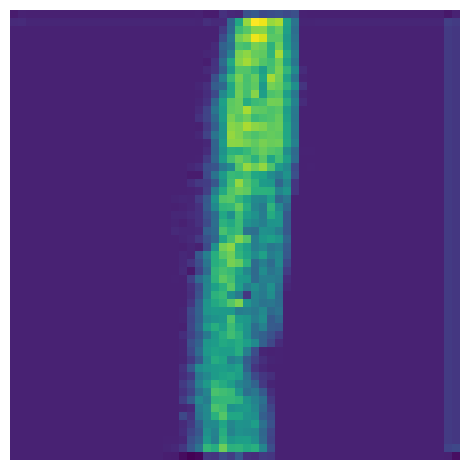

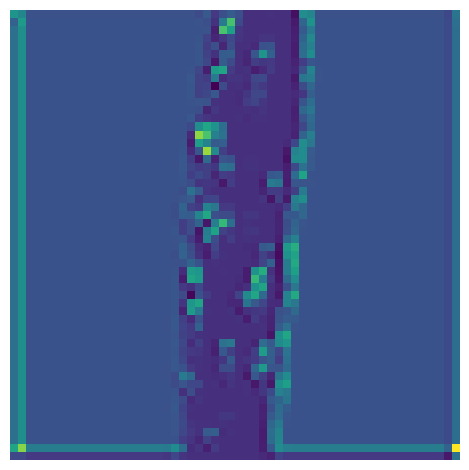

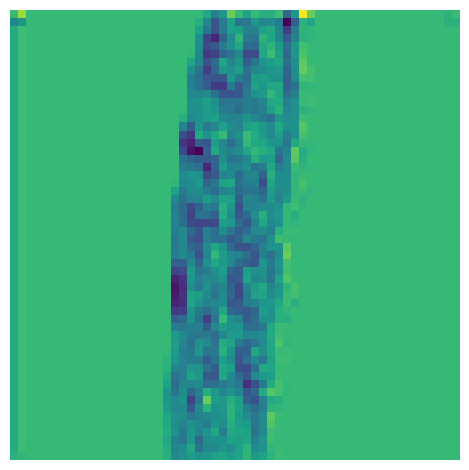

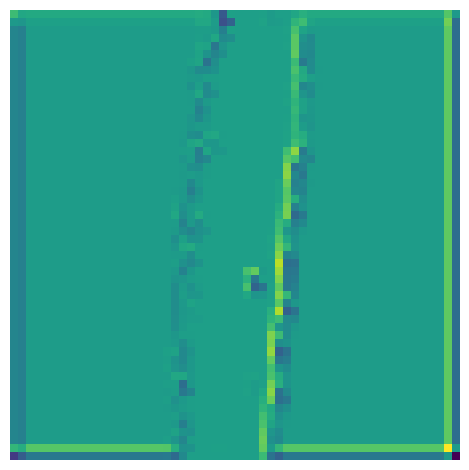

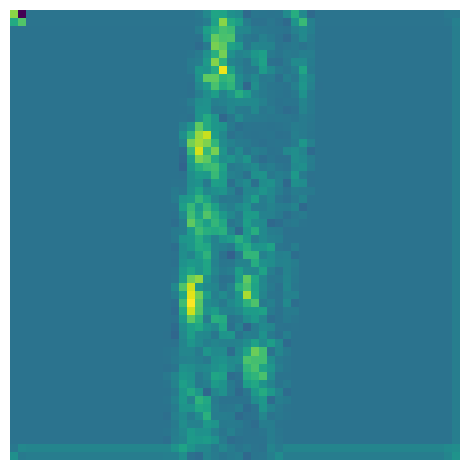

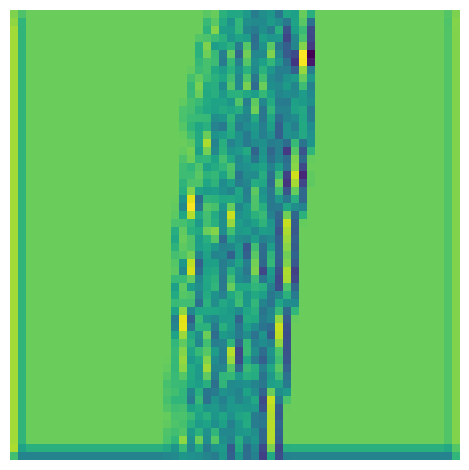

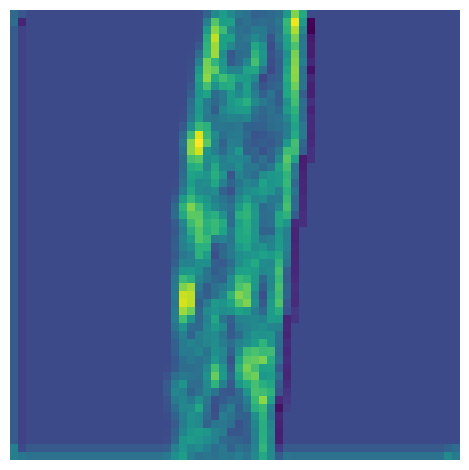

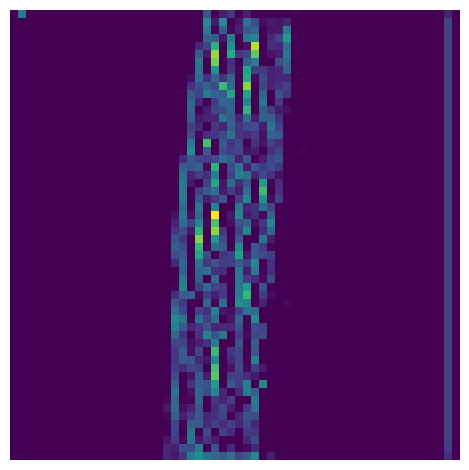

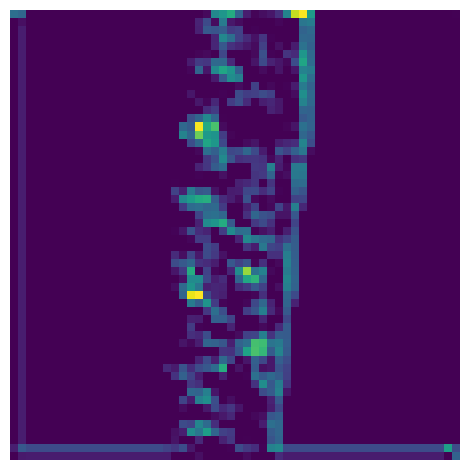

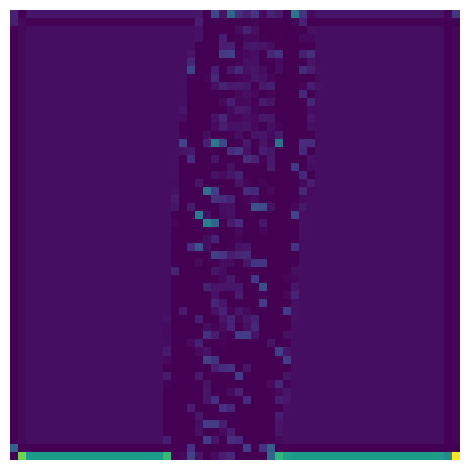

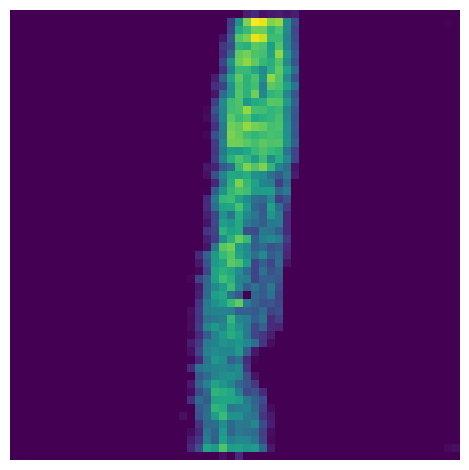

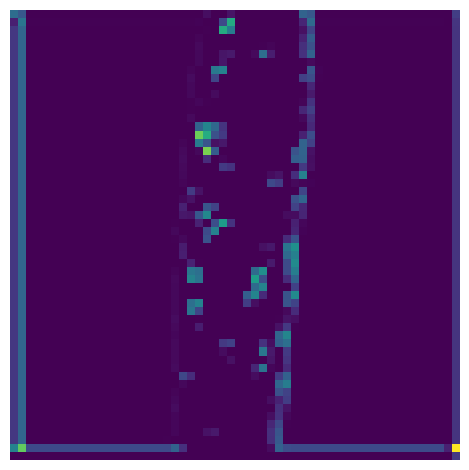

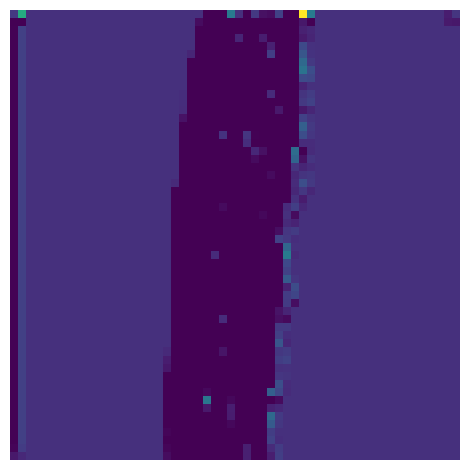

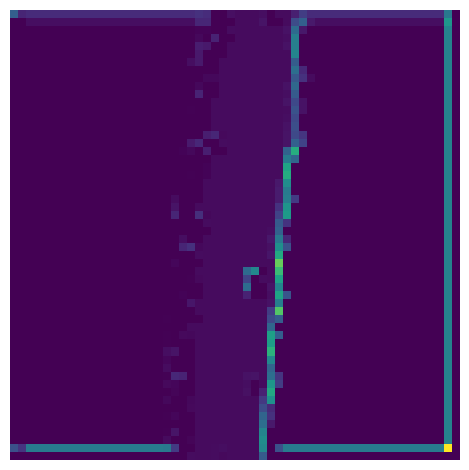

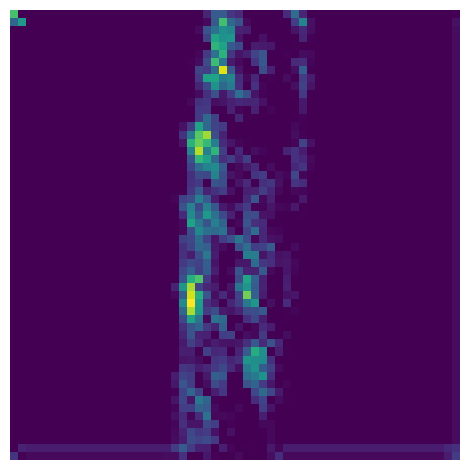

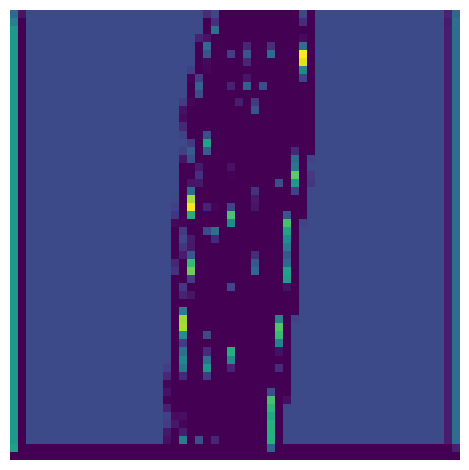

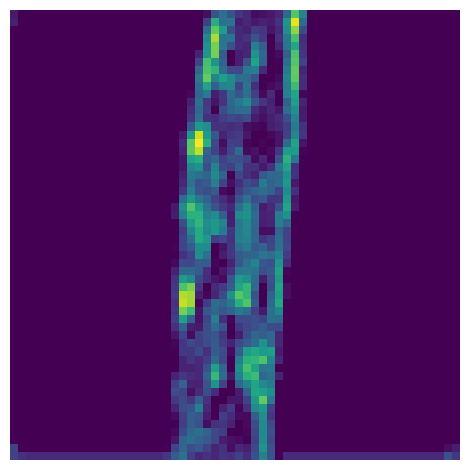

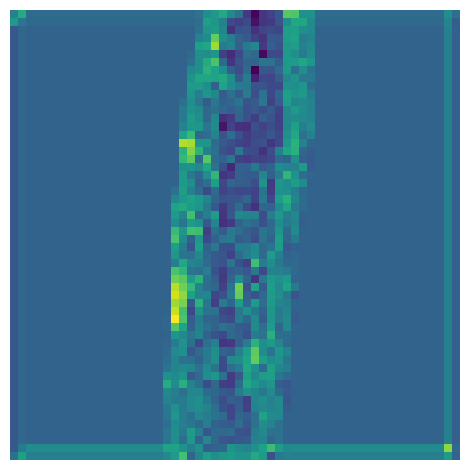

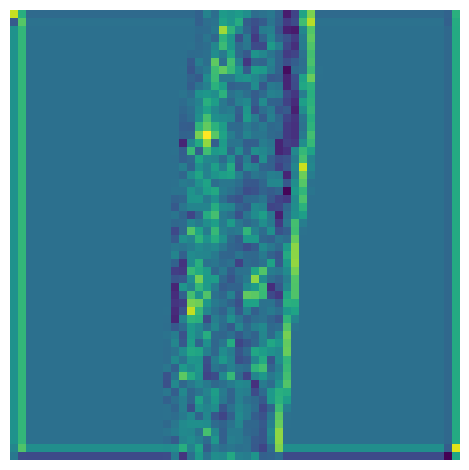

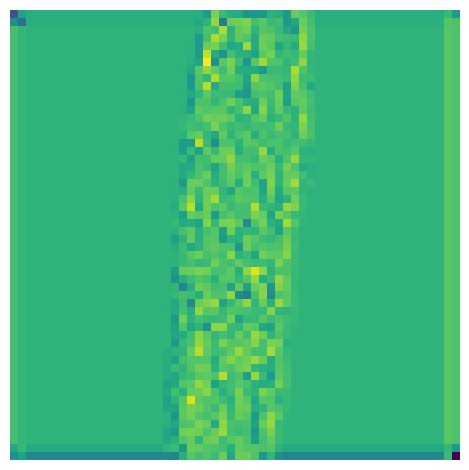

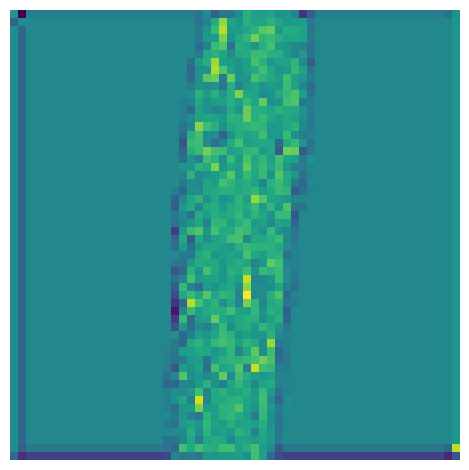

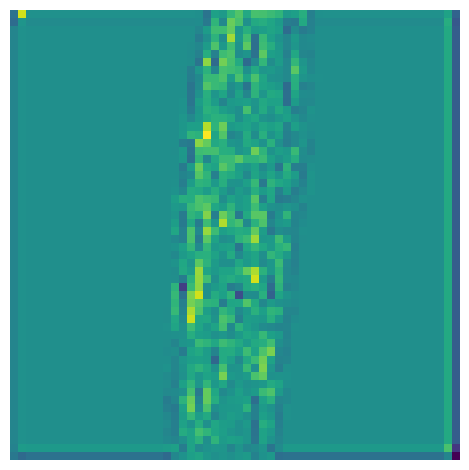

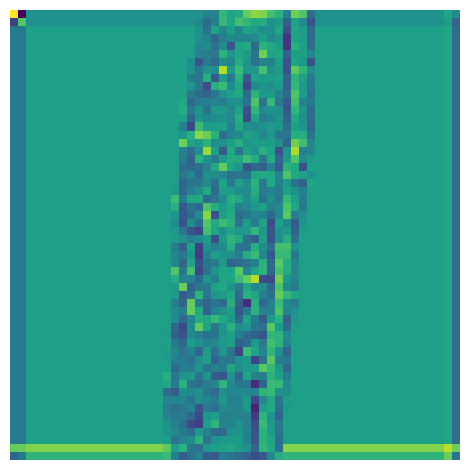

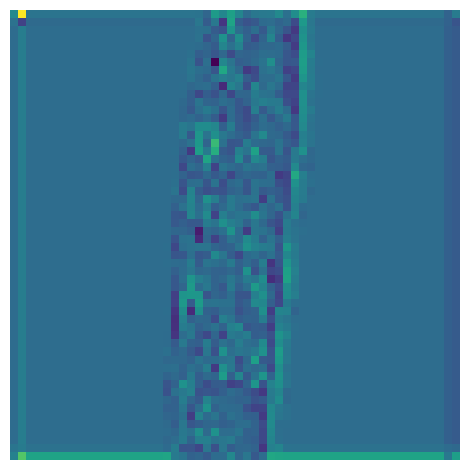

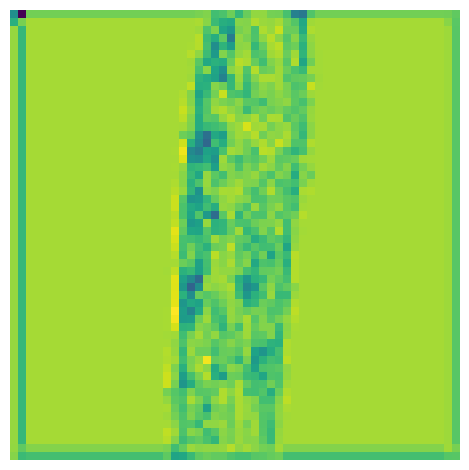

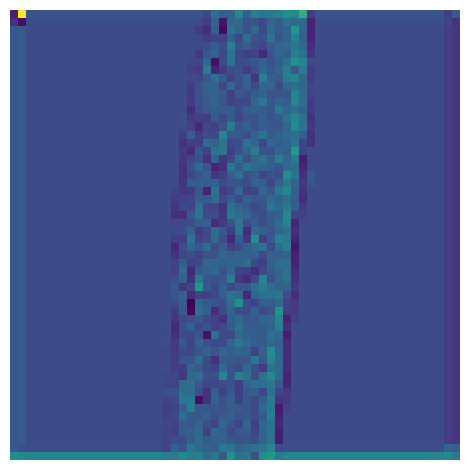

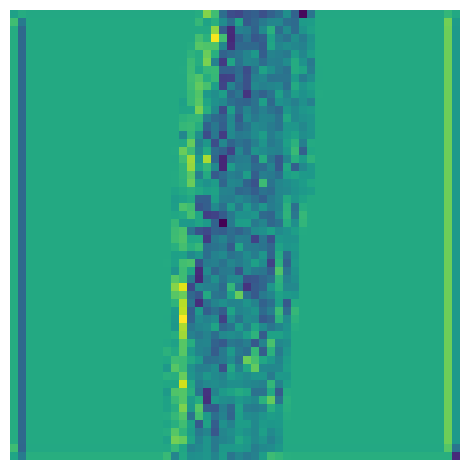

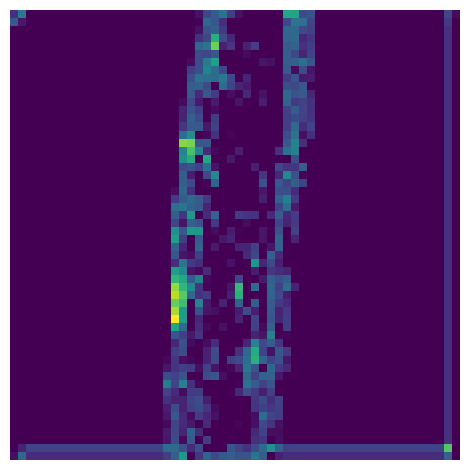

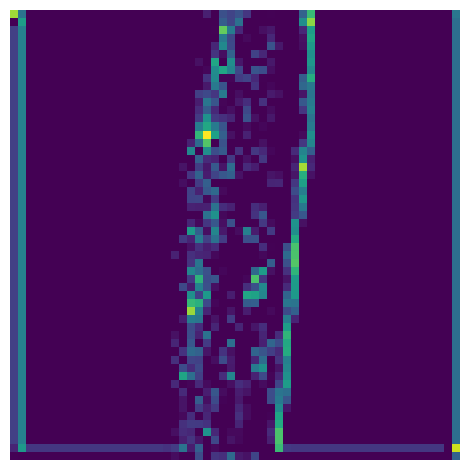

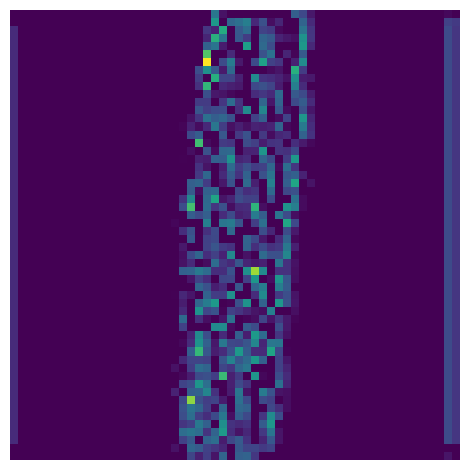

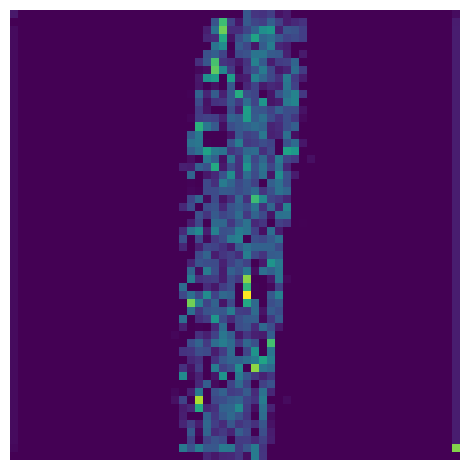

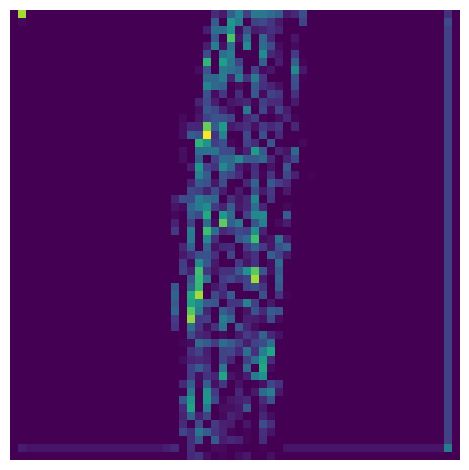

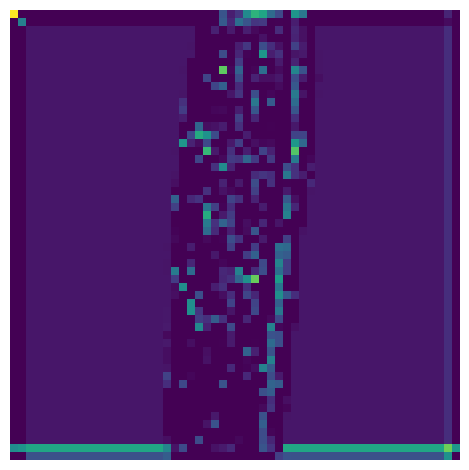

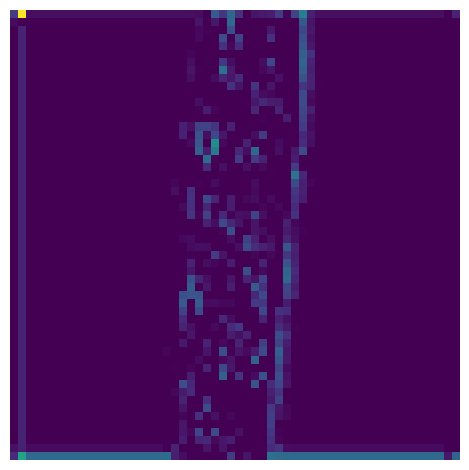

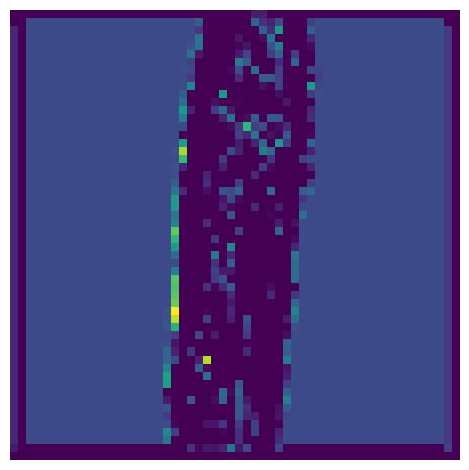

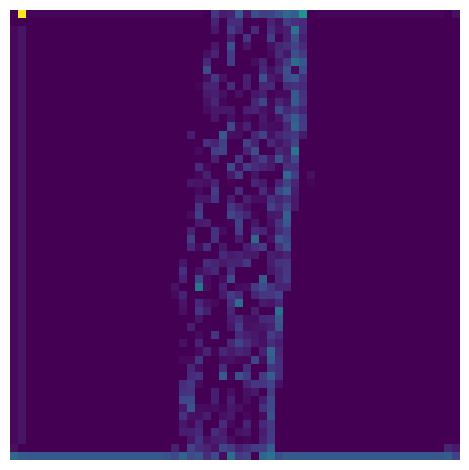

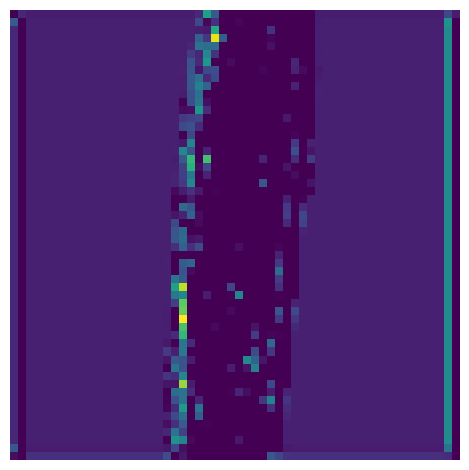

In [43]:
for name in activation_names:
    folder_path = os.path.join('custom_1', name)
    file = name

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    if file in activation1:
        num_images = min(max(3, activation1[file].shape[1]), 10)
        for i in range(num_images):
            fig, ax = plt.subplots(1, 1)
            ax.imshow(activation1[file][0, i].cpu().numpy())
            ax.axis('off')
            plt.tight_layout()

            fig.savefig(f'{folder_path}/{file}-{i}.png', dpi=300, transparent=True)


tensor([[[[1.0000, 1.0000, 0.8549, 0.6392, 0.9765, 1.0000],
          [1.0000, 1.0000, 0.8078, 0.6471, 0.9804, 1.0000],
          [1.0000, 1.0000, 0.7686, 0.6863, 0.9882, 1.0000],
          [1.0000, 0.9961, 0.7529, 0.7333, 0.9961, 1.0000],
          [1.0000, 0.9961, 0.7490, 0.7922, 1.0000, 1.0000],
          [1.0000, 0.9961, 0.7412, 0.8235, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 0.8863, 0.7451, 0.9843, 1.0000],
          [1.0000, 1.0000, 0.8549, 0.7647, 0.9882, 1.0000],
          [1.0000, 1.0000, 0.8118, 0.7686, 0.9922, 1.0000],
          [1.0000, 1.0000, 0.8078, 0.7922, 0.9961, 1.0000],
          [1.0000, 0.9961, 0.8235, 0.8392, 1.0000, 1.0000],
          [1.0000, 0.9961, 0.8353, 0.8824, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 0.7294, 0.4157, 0.9569, 1.0000],
          [1.0000, 1.0000, 0.6353, 0.4275, 0.9647, 1.0000],
          [1.0000, 0.9961, 0.5569, 0.4706, 0.9804, 1.0000],
          [1.0000, 0.9922, 0.5333, 0.5294, 0.9922, 1.0000],
          [1.0000, 0.9882, 0.5255, 0

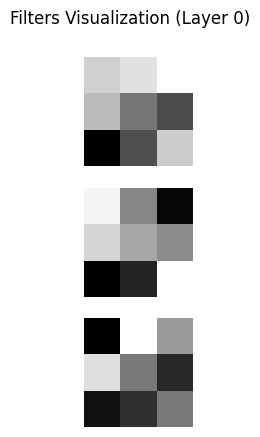

bias :tensor([-0.1724, -0.1433, -0.0995])


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def visualize_filters(model, layer_idx):
    layer = model.feature[layer_idx][0]
    filters = layer.weight.data
    filters = filters - filters.min()
    filters = filters / filters.max()

    fig, axs = plt.subplots(filters.size(0))
    fig.suptitle('Filters Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        filter_img = filters[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(filter_img.squeeze(), cmap='gray')  
        ax.axis('off')
        print(f"filer :{filter_img}")

    plt.show()
    
def visualize_bias(model, layer_idx):
    layer = model.feature[layer_idx][0]
    bias = layer.bias.data

    fig, ax = plt.subplots()
    fig.suptitle('Bias Visualization (Layer {})'.format(layer_idx))

    ax.plot(bias.cpu().numpy())
    ax.set_xlabel('Filter Index')
    ax.set_ylabel('Bias Value')
    print(f"bias :{bias}")
    plt.show()
    
    

def visualize_feature_maps(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    activations = activations.detach()

    fig, axs = plt.subplots(activations.size(1))
    fig.suptitle('Feature Map Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"fitur :{activations}")

    plt.show()

def visualize_relu(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    relu_activations = torch.relu(activations)
    relu_activations = relu_activations.detach()

    fig, axs = plt.subplots(relu_activations.size(1))
    fig.suptitle('ReLU Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(relu_activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"relu :{relu_activations}")

    plt.show()

output_size = 10  
model = CNNpenyakitPadi(output_size)

transform = transforms.Compose([
    transforms.Resize((6,6)),
    transforms.ToTensor()
])

image_path = '/kaggle/input/dataset-rice-leaf/RiceLeafsDisease/test/brown_spot/brown_val (53).jpg' 
input_image = Image.open(image_path)
input_image = transform(input_image).unsqueeze(0)


print(input_image)


visualize_filters(model, 0)

visualize_bias(model, 0)

visualize_feature_maps(model, 0, input_image)

visualize_relu(model, 0, input_image)